# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

## Функции загрузки данных

In [11]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return tf.keras.applications.resnet50.preprocess_input(img)  # предобработка для ResNet

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

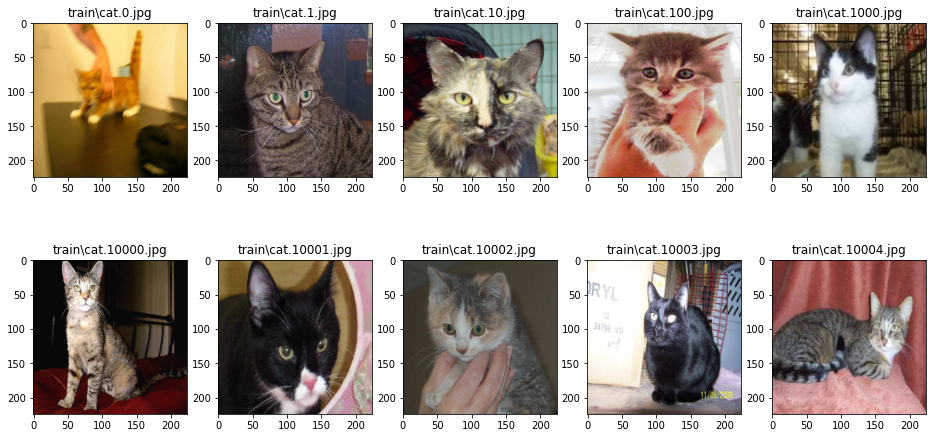

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [25]:
base_model = tf.keras.applications.ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

## Добавляем полносвязный слой

In [26]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Компилируем модель и запускаем обучение

In [27]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [28]:
val_samples = 100  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=5,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/5
10/10 [==============================] - 5s 275ms/step - loss: 0.3653 - accuracy: 0.8750 - val_loss: 0.1186 - val_accuracy: 0.9800
Epoch 2/5
10/10 [==============================] - 2s 184ms/step - loss: 0.1283 - accuracy: 0.9656 - val_loss: 0.0837 - val_accuracy: 0.9800
Epoch 3/5
10/10 [==============================] - 2s 183ms/step - loss: 0.1056 - accuracy: 0.9750 - val_loss: 0.0741 - val_accuracy: 0.9800
Epoch 4/5
10/10 [==============================] - 2s 184ms/step - loss: 0.0520 - accuracy: 0.9937 - val_loss: 0.0775 - val_accuracy: 0.9800
Epoch 5/5
10/10 [==============================] - 2s 184ms/step - loss: 0.0898 - accuracy: 0.9719 - val_loss: 0.0644 - val_accuracy: 0.9800


In [56]:
model.save('cats-dogs-resnet50.hdf5')

## Предсказания на проверочной выборке

In [29]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

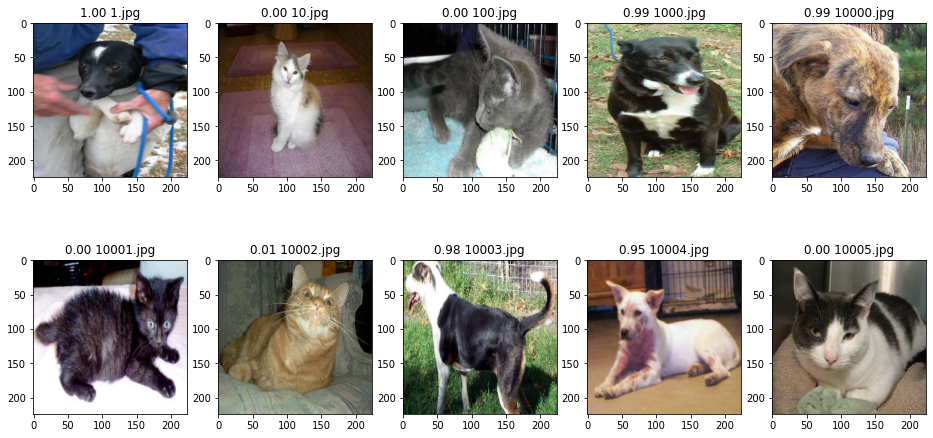

In [30]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [31]:
import re

with open('submit2.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

#### LogLoss 0.075